<a href="https://colab.research.google.com/github/luciamartinf/BigData/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet50 Model 

#### Ángela Gómez Sacristán, Álvaro González Berdasco y Lucía Martín Fernández

## Import libraries


In [ ]:
import numpy as np
import pandas as pd

import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
%matplotlib inline
import glob
import random
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from keras.utils.vis_utils import plot_model

## Load and transform data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Data paths
train_dir="/content/drive/MyDrive/Colab Notebooks/chest_xray/train/"
val_dir="/content/drive/MyDrive/Colab Notebooks/chest_xray/val/"
test_dir="/content/drive/MyDrive/Colab Notebooks/chest_xray/test/"

In [ ]:
# Fetch the dataset from the directories
# Re-sizing the images
IMAGE_SIZE = (224, 224)
# Default batch size
BATCH_SIZE = 32

In [ ]:
# Keras ImageDataGenerator
image_gen = ImageDataGenerator(
        rescale = 1/255,
        shear_range=10,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5,2.0],
        width_shift_range = 0.2,
        rotation_range=20,
        fill_mode = 'nearest'
)

val_datagen = ImageDataGenerator(
        rescale = 1/255
)

In [ ]:
# Flow from directory
train = image_gen.flow_from_directory(train_dir, batch_size=32, class_mode='binary')

validation = image_gen.flow_from_directory(val_dir, batch_size=2, class_mode='binary')

test = val_datagen.flow_from_directory(test_dir, batch_size=2, class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
img, label = next(train)

In [ ]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10)

In [ ]:
# ReduceLROnPlateau
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                          patience=8)

## ResNet50 Model

### Model Building

In [ ]:
def create_model():
    resnet_model = tf.keras.applications.ResNet50V2(
        weights='imagenet',
        include_top = False,
        input_shape = (224,224,3)
    )

    for layer in resnet_model.layers:
        layer.trainable=False

    x = resnet_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128,activation='relu')(x)
    # output layer
    predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

    res_model = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

    # Compiling the model
    res_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    return res_model

In [ ]:
res_model = create_model()

94668760/94668760 [==============================] - 0s 0us/step


In [ ]:
res_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

### Fitting model

In [ ]:
history = res_model.fit(train,epochs=30, 
                    validation_data=validation,
                     steps_per_epoch=10,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

Epoch 1/30
10/10 [==============================] - 151s 8s/step - loss: 0.6800 - accuracy: 0.7219 - val_loss: 0.6857 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 2/30
10/10 [==============================] - 77s 7s/step - loss: 0.3304 - accuracy: 0.8625 - val_loss: 0.6756 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/30
10/10 [==============================] - 76s 7s/step - loss: 0.3097 - accuracy: 0.8500 - val_loss: 1.1418 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/30
10/10 [==============================] - 74s 7s/step - loss: 0.2320 - accuracy: 0.9062 - val_loss: 0.6580 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/30
10/10 [==============================] - 77s 7s/step - loss: 0.2679 - accuracy: 0.8781 - val_loss: 0.9237 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 6/30
10/10 [==============================] - 76s 7s/step - loss: 0.2950 - accuracy: 0.8719 - val_loss: 0.6212 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 7/30
10/10 [==============================] - 77s 8s/step - loss: 0.1634 - 

### Model performance

**Accuracy** **& Loss for each** **epoch**

Text(0, 0.5, 'Loss')

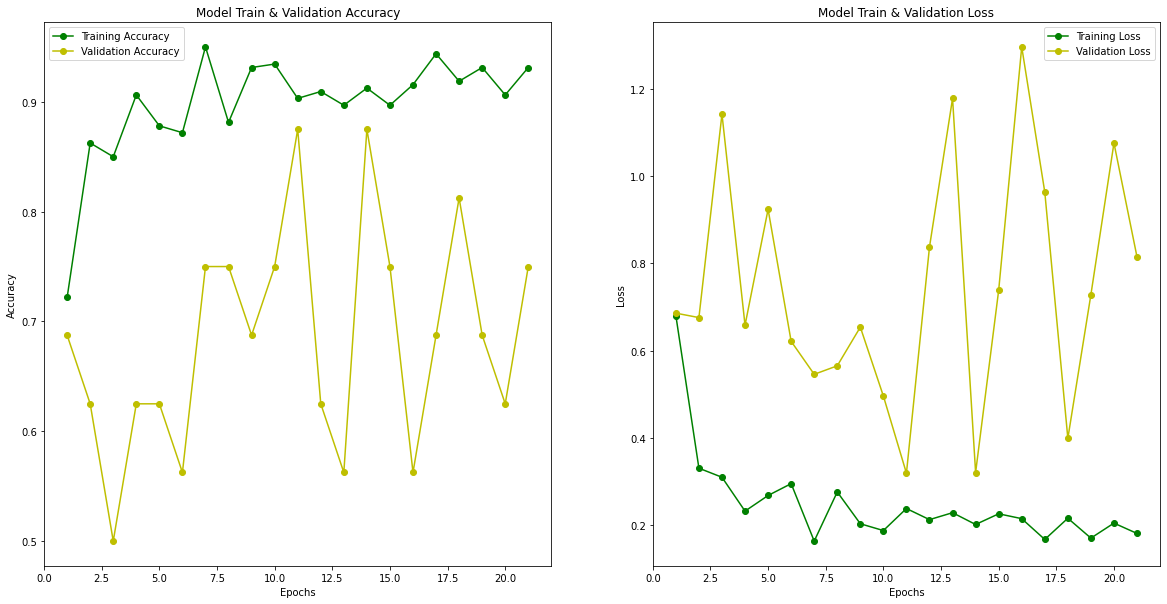

In [ ]:
#Plot the training artifacts
fig , ax = plt.subplots(1, 2)
fig.set_size_inches(20, 10)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs, train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'yo-' , label = 'Validation Accuracy')
ax[0].set_title('Model Train & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs, val_loss , 'yo-' , label = 'Validation Loss')
ax[1].set_title('Model Train & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

### Model evaluation

In [ ]:
# Evaluating the model on train and test
evaluation_train = res_model.evaluate(train)

print("Train Loss: ", evaluation_train[0])
print("Train Accuracy: ", evaluation_train[1])

evaluation_test = res_model.evaluate(test)
print("\nTest loss: ", evaluation_test[0])
print("Test Accuracy: ", evaluation_test[1])

163/163 [==============================] - 1149s 7s/step - loss: 0.1887 - accuracy: 0.9237
Train Loss:  0.1886528730392456
Train Accuracy:  0.9236963391304016
312/312 [==============================] - 142s 456ms/step - loss: 0.2596 - accuracy: 0.8958

Test loss:  0.2596129775047302
Test Accuracy:  0.8958333134651184


Resnet50 shows that we could create a model with a great number of layers and reach very good results, as we can see in the accuracy of the train dataset.